#Op Return Layer 2

<a href="https://colab.research.google.com/github/ProfDoeg/Colegio_Invisible/blob/master/11_cuaderno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparar el Espacio (Prepare the Space)

In [132]:
! pip install eciespy eth_keys cryptos qrcode base58 
! git clone https://github.com/ProfDoeg/Colegio_Invisible.git

fatal: destination path 'Colegio_Invisible' already exists and is not an empty directory.


# Importaciones y Definiciones (Imports and Definitions)

Crear funciones para importar claves y direcciones de criptomonedas.
***
Create functions for importing keys and cryptocurrency addresses.

In [133]:
import pandas as pd
from cryptos.py3specials import safe_hexlify, from_string_to_bytes, from_int_to_byte, from_string_to_bytes
from cryptos import serialize,deserialize

import hashlib
import os
import getpass
import ecies
import eth_keys
import cryptos
import qrcode
import base58
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [134]:
def import_privKey(privkey_filepath,password=None):
    if password==None:
        password = getpass.getpass("Input password for decrypting keyfile: ")
    password=password.encode()
    f=open(privkey_filepath,'rb')
    decrypted_bytes=ecies.aes_decrypt(key=hashlib.sha256(password).digest(),cipher_text=f.read())
    privKey=eth_keys.keys.PrivateKey(decrypted_bytes)
    return privKey

def import_pubKey(pubkey_filepath):
    f=open(pubkey_filepath,'rb')
    privKey=eth_keys.keys.PublicKey(f.read())
    return privKey

def import_addr(addr_filepath):
    return open(addr_filepath,'rb').read().decode()

def only_conf(utxos):
    return [utxo for utxo in utxos
            if doge.fetchtx(utxo['output'].split(':')[0])['confirmations']>0]

def mk_opreturn(msg, rawtx=None, json=0):
    
    def op_push(data):
        if type(data) == bytes:
            bytedata=data
        else:
            bytedata=data.encode()
        import struct
        if len(data) < 0x4c:
            return from_int_to_byte(len(bytedata)) + bytedata
        elif len(data) < 0xff:
            return from_int_to_byte(76) + struct.pack('<B', len(bytedata)) + bytedata
        elif len(data) < 0xffff:
            return from_int_to_byte(77) + struct.pack('<H', len(bytedata)) + bytedata
        elif len(data) < 0xffffffff:
            return from_int_to_byte(78) + struct.pack('<I', len(bytedata)) + bytedata
        else: raise Exception("Input data error. Rawtx must be hex chars" \
                            + "0xffffffff > len(data) > 0")

    orhex = safe_hexlify(b'\x6a' + op_push(msg))
    orjson = {'script' : orhex, 'value' : 0}
    if rawtx is not None:
        try:
            txo = deserialize(rawtx)
            if not 'outs' in txo.keys(): raise Exception("OP_Return cannot be the sole output!")
            txo['outs'].append(orjson)
            newrawtx = serialize(txo)
            return newrawtx
        except Exception as E:
            print(E)
            print(type(E))
            raise Exception("Raw Tx Error!")
    return orhex if not json else orjson

# Comenzar con Claves Existentes (Start with Existing Keys)

Acceder a las claves generadas en el cuaderno 5
***
Access the keys generated in the cuaderno 5

## Comenzar con Claves en Google Drive (Start with Keys on Google Drive)

In [135]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [136]:
! cp drive/MyDrive/cinv/llaves.zip llaves.zip 
! unzip llaves.zip


Archive:  llaves.zip
replace llaves/mi_addr.bin? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: llaves/mi_addr.bin      
 extracting: llaves/mi_addr.png      
 extracting: llaves/mi_pub.bin       
 extracting: llaves/mi_prv.enc       


## Comenzar con Claves en la Disco Local
## (Start with Keys on Local Drive)

In [ ]:
#from google.colab import files
#fu=files.upload();

In [ ]:
#! unzip llaves.zip

In [ ]:
#! ls llaves

# Import Private Key, Public Key and Address

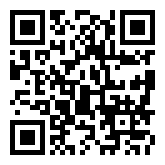

'0x7c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5'

'D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX'

In [137]:
from IPython.display import Image
qr=Image('llaves/mi_addr.png')

privKey=import_privKey('llaves/mi_prv.enc','')
pub=import_pubKey('llaves/mi_pub.bin').to_hex()
addr=import_addr('llaves/mi_addr.bin')

display(qr)
display(pub)
display(addr)

In [138]:
message='''Radio, live transmission.
Radio, live transmission.

Listen to the silence, let it ring on.
Eyes, dark grey lenses frightened of the sun.
We would have a fine time living in the night,
Left to blind destruction,
Waiting for our sight.

And we would go on as though nothing was wrong.
And hide from these days we remained all alone.
Staying in the same place, just staying out the time.
Touching from a distance,
Further all the time.

Dance, dance, dance, dance, dance, to the radio.
Dance, dance, dance, dance, dance, to the radio...

Well I could call out when the going gets tough.
The things that we've learnt are no longer enough.
No language, just sound, that's all we need know,
To synchronise love to the beat of the show.

And we could dance.

Dance, dance, dance, dance, dance, to the radio.
Dance, dance, dance, dance, dance, to the radio...
'''.encode()

In [139]:
message1='''Bajan

Tengo tiempo para saber
Si lo que sueño concluye en algo
No te apures ya más loco
Porque es entonces cuando las horas
Bajan, el día es vidrio sin sol
Bajan, la noche te oculta la voz
Y además vos querés sol
Despacio también podés hallar la luna
Viejo roble del camino, tus hojas siempre se agitan algo
Nena, nena, que bien te ves
Cuando en tus ojos no importa si las horas
Bajan, la noche es día sin sol
Bajan, el día que nunca acabó
Y además vos sos el sol
Despacio también podés ser la luna'''.encode()

In [140]:
message3='''Blue Monday

How does it feel
When you treat me like you do
And you've laid your hands upon me
And told me who you are?
I thought I was mistaken
And I thought I heard your words
Tell me, how do I feel?
Tell me now, how do I feel?
Those who came before me
Lived through their vocations
From the past until completion
They will turn away no more
And I still find it so hard
To say what I need to say
But I'm quite sure that you'll tell me
Just how I should feel today
I see a ship in the harbor
I can and shall obey
But if it wasn't for your misfortunes
I'd be a heavenly person today
And I thought I was mistaken
And I thought I heard you speak
Tell me how do I feel?
Tell me now, how should I feel?
Now I stand here waiting
I thought I told you to leave me
While I walked down to the beach
Tell me, how does it feel
When your heart grows cold?
How does it feel?
How does it feel?
How does it feel?
And I thought I told you to leave me
While I walked down to the beach
Tell me, how does it feel
When your heart grows cold'''.encode()

In [143]:
type(message3)

bytes

In [146]:
len(message3)

1020

In [ ]:
list(range(0, len(message), 76))

In [147]:
#message='hello to the world. this is a message to everyone who likes gravy. slow down. it is not healthy. it is too thick and sloppy'.encode()
n = 76 
chunks = [message[i:i+n] for i in range(0, len(message), n)]
chunks

[b'Radio, live transmission.\nRadio, live transmission.\n\nListen to the silence, ',
 b'let it ring on.\nEyes, dark grey lenses frightened of the sun.\nWe would have ',
 b'a fine time living in the night,\nLeft to blind destruction,\nWaiting for our ',
 b'sight.\n\nAnd we would go on as though nothing was wrong.\nAnd hide from these ',
 b'days we remained all alone.\nStaying in the same place, just staying out the ',
 b'time.\nTouching from a distance,\nFurther all the time.\n\nDance, dance, dance, ',
 b'dance, dance, to the radio.\nDance, dance, dance, dance, dance, to the radio.',
 b"..\n\nWell I could call out when the going gets tough.\nThe things that we've l",
 b"earnt are no longer enough.\nNo language, just sound, that's all we need know",
 b',\nTo synchronise love to the beat of the show.\n\nAnd we could dance.\n\nDance, ',
 b'dance, dance, dance, dance, to the radio.\nDance, dance, dance, dance, dance,',
 b' to the radio...\n']

In [148]:
def pieces(bites,size):
    return [bites[i:i+size] for i in range(0, len(bites), size)]

In [149]:
def prepend_index(L):
    return [ int(i).to_bytes(1, 'big')+int(len(L)-1).to_bytes(1, 'big')+chunk for i,chunk in enumerate(L)]

In [150]:
def prepend_head(L,byte_head):
    return [ byte_head+chunk for chunk in L]

# byte head contains leading byte "\xdd" and byte to represent embed type
# a single line text will be embed type "\x00"
# a single line hash will be embed type "\x01"
# a multiline text will be embed type "\x02"
# a multiline ecies encrypted text will be embed type "\x03"

In [151]:
def multiline_setup(mensaje):
    mensaje_partes=pieces(mensaje,76)
    indexed_mensaje_partes=prepend_index(mensaje_partes)
    return prepend_head(indexed_mensaje_partes,b'\xdd\x02')

In [152]:
chunks=pieces(message,76)
chunks

[b'Radio, live transmission.\nRadio, live transmission.\n\nListen to the silence, ',
 b'let it ring on.\nEyes, dark grey lenses frightened of the sun.\nWe would have ',
 b'a fine time living in the night,\nLeft to blind destruction,\nWaiting for our ',
 b'sight.\n\nAnd we would go on as though nothing was wrong.\nAnd hide from these ',
 b'days we remained all alone.\nStaying in the same place, just staying out the ',
 b'time.\nTouching from a distance,\nFurther all the time.\n\nDance, dance, dance, ',
 b'dance, dance, to the radio.\nDance, dance, dance, dance, dance, to the radio.',
 b"..\n\nWell I could call out when the going gets tough.\nThe things that we've l",
 b"earnt are no longer enough.\nNo language, just sound, that's all we need know",
 b',\nTo synchronise love to the beat of the show.\n\nAnd we could dance.\n\nDance, ',
 b'dance, dance, dance, dance, to the radio.\nDance, dance, dance, dance, dance,',
 b' to the radio...\n']

In [153]:
indexed_chunks=prepend_index(chunks)
indexed_chunks

[b'\x00\x0bRadio, live transmission.\nRadio, live transmission.\n\nListen to the silence, ',
 b'\x01\x0blet it ring on.\nEyes, dark grey lenses frightened of the sun.\nWe would have ',
 b'\x02\x0ba fine time living in the night,\nLeft to blind destruction,\nWaiting for our ',
 b'\x03\x0bsight.\n\nAnd we would go on as though nothing was wrong.\nAnd hide from these ',
 b'\x04\x0bdays we remained all alone.\nStaying in the same place, just staying out the ',
 b'\x05\x0btime.\nTouching from a distance,\nFurther all the time.\n\nDance, dance, dance, ',
 b'\x06\x0bdance, dance, to the radio.\nDance, dance, dance, dance, dance, to the radio.',
 b"\x07\x0b..\n\nWell I could call out when the going gets tough.\nThe things that we've l",
 b"\x08\x0bearnt are no longer enough.\nNo language, just sound, that's all we need know",
 b'\t\x0b,\nTo synchronise love to the beat of the show.\n\nAnd we could dance.\n\nDance, ',
 b'\n\x0bdance, dance, dance, dance, to the radio.\nDance, dance, dance, danc

In [154]:
headed_chunks=prepend_head(indexed_chunks,b'\xdd\x02')
headed_chunks

[b'\xdd\x02\x00\x0bRadio, live transmission.\nRadio, live transmission.\n\nListen to the silence, ',
 b'\xdd\x02\x01\x0blet it ring on.\nEyes, dark grey lenses frightened of the sun.\nWe would have ',
 b'\xdd\x02\x02\x0ba fine time living in the night,\nLeft to blind destruction,\nWaiting for our ',
 b'\xdd\x02\x03\x0bsight.\n\nAnd we would go on as though nothing was wrong.\nAnd hide from these ',
 b'\xdd\x02\x04\x0bdays we remained all alone.\nStaying in the same place, just staying out the ',
 b'\xdd\x02\x05\x0btime.\nTouching from a distance,\nFurther all the time.\n\nDance, dance, dance, ',
 b'\xdd\x02\x06\x0bdance, dance, to the radio.\nDance, dance, dance, dance, dance, to the radio.',
 b"\xdd\x02\x07\x0b..\n\nWell I could call out when the going gets tough.\nThe things that we've l",
 b"\xdd\x02\x08\x0bearnt are no longer enough.\nNo language, just sound, that's all we need know",
 b'\xdd\x02\t\x0b,\nTo synchronise love to the beat of the show.\n\nAnd we could dance.\n\nDance, 

In [155]:
opreturn_list=multiline_setup(message)
opreturn_list

[b'\xdd\x02\x00\x0bRadio, live transmission.\nRadio, live transmission.\n\nListen to the silence, ',
 b'\xdd\x02\x01\x0blet it ring on.\nEyes, dark grey lenses frightened of the sun.\nWe would have ',
 b'\xdd\x02\x02\x0ba fine time living in the night,\nLeft to blind destruction,\nWaiting for our ',
 b'\xdd\x02\x03\x0bsight.\n\nAnd we would go on as though nothing was wrong.\nAnd hide from these ',
 b'\xdd\x02\x04\x0bdays we remained all alone.\nStaying in the same place, just staying out the ',
 b'\xdd\x02\x05\x0btime.\nTouching from a distance,\nFurther all the time.\n\nDance, dance, dance, ',
 b'\xdd\x02\x06\x0bdance, dance, to the radio.\nDance, dance, dance, dance, dance, to the radio.',
 b"\xdd\x02\x07\x0b..\n\nWell I could call out when the going gets tough.\nThe things that we've l",
 b"\xdd\x02\x08\x0bearnt are no longer enough.\nNo language, just sound, that's all we need know",
 b'\xdd\x02\t\x0b,\nTo synchronise love to the beat of the show.\n\nAnd we could dance.\n\nDance, 

In [156]:
opreturn_list1=multiline_setup(message1)
opreturn_list1

[b'\xdd\x02\x00\x06Bajan\n\nTengo tiempo para saber\nSi lo que sue\xc3\xb1o concluye en algo\nNo te apure',
 b'\xdd\x02\x01\x06s ya m\xc3\xa1s loco\nPorque es entonces cuando las horas\nBajan, el d\xc3\xada es vidrio ',
 b'\xdd\x02\x02\x06sin sol\nBajan, la noche te oculta la voz\nY adem\xc3\xa1s vos quer\xc3\xa9s sol\nDespacio ',
 b'\xdd\x02\x03\x06tambi\xc3\xa9n pod\xc3\xa9s hallar la luna\nViejo roble del camino, tus hojas siempre se ',
 b'\xdd\x02\x04\x06agitan algo\nNena, nena, que bien te ves\nCuando en tus ojos no importa si las',
 b'\xdd\x02\x05\x06 horas\nBajan, la noche es d\xc3\xada sin sol\nBajan, el d\xc3\xada que nunca acab\xc3\xb3\nY ade',
 b'\xdd\x02\x06\x06m\xc3\xa1s vos sos el sol\nDespacio tambi\xc3\xa9n pod\xc3\xa9s ser la luna']

In [157]:
opreturn_list3=multiline_setup(message3)
opreturn_list3

[b"\xdd\x02\x00\rBlue Monday\n\nHow does it feel\nWhen you treat me like you do\nAnd you've laid ",
 b'\xdd\x02\x01\ryour hands upon me\nAnd told me who you are?\nI thought I was mistaken\nAnd I t',
 b'\xdd\x02\x02\rhought I heard your words\nTell me, how do I feel?\nTell me now, how do I feel',
 b'\xdd\x02\x03\r?\nThose who came before me\nLived through their vocations\nFrom the past until',
 b'\xdd\x02\x04\r completion\nThey will turn away no more\nAnd I still find it so hard\nTo say w',
 b"\xdd\x02\x05\rhat I need to say\nBut I'm quite sure that you'll tell me\nJust how I should f",
 b"\xdd\x02\x06\reel today\nI see a ship in the harbor\nI can and shall obey\nBut if it wasn't f",
 b"\xdd\x02\x07\ror your misfortunes\nI'd be a heavenly person today\nAnd I thought I was mista",
 b'\xdd\x02\x08\rken\nAnd I thought I heard you speak\nTell me how do I feel?\nTell me now, how ',
 b'\xdd\x02\t\rshould I feel?\nNow I stand here waiting\nI thought I told you to leave me\nWhi',
 b'\xdd\x02\n\

In [158]:
def embed_message_list(L,privkeyhex,tip=2_00_000_000):
    import time
    txn_ids=[]
    doge=cryptos.Doge()
    addy=doge.privtoaddr(privkeyhex)
    doge_unspents=only_conf( doge.unspent(addy) )
    doge_unspent_total=sum([unspent['value'] for unspent in doge_unspents])
    if ( tip*len(L) + 3_00_000_000 ) > doge_unspent_total:
        raise Exception("Not enough coins available")
    # at this point we know we have enough coins...
    # now we will iterate through the list
    for op_return in L:
        print(op_return)
    # make sure to wait for utxos to confirm, if not wait 10 sec
        while True:
            doge_unspents=only_conf( doge.unspent(addy) )
            if doge_unspents != []:
              print('COINS UP')
              break
            time.sleep(20)
        doge_unspent_total=sum([unspent['value'] for unspent in doge_unspents]) 
        doge_gift=doge_unspent_total-tip
        doge_outputs=[ {'value':doge_gift , 'address': addy}]
        doge_tx=doge.mktx(doge_unspents,doge_outputs)
        doge_serial_tx=cryptos.serialize(doge_tx)
        doge_inscribed_serial_tx=mk_opreturn( op_return , doge_serial_tx)
        doge_inscribed_tx=cryptos.deserialize(doge_inscribed_serial_tx)
        doge_signed_inscribed_tx=doge.signall(doge_inscribed_tx,privkeyhex)
        broadcast_doge_signed_inscribed_tx=doge.pushtx(doge_signed_inscribed_tx)
        txn_ids.append(broadcast_doge_signed_inscribed_tx['data']['txid'])
    return txn_ids

In [166]:
txns3=embed_message_list(opreturn_list3,privKey.to_hex()[2:],tip=2_00_000_000)
txns3

b"\xdd\x02\x00\rBlue Monday\n\nHow does it feel\nWhen you treat me like you do\nAnd you've laid "
COINS UP
b'\xdd\x02\x01\ryour hands upon me\nAnd told me who you are?\nI thought I was mistaken\nAnd I t'
COINS UP
b'\xdd\x02\x02\rhought I heard your words\nTell me, how do I feel?\nTell me now, how do I feel'
COINS UP
b'\xdd\x02\x03\r?\nThose who came before me\nLived through their vocations\nFrom the past until'
COINS UP
b'\xdd\x02\x04\r completion\nThey will turn away no more\nAnd I still find it so hard\nTo say w'
COINS UP
b"\xdd\x02\x05\rhat I need to say\nBut I'm quite sure that you'll tell me\nJust how I should f"
COINS UP
b"\xdd\x02\x06\reel today\nI see a ship in the harbor\nI can and shall obey\nBut if it wasn't f"
COINS UP
b"\xdd\x02\x07\ror your misfortunes\nI'd be a heavenly person today\nAnd I thought I was mista"
COINS UP
b'\xdd\x02\x08\rken\nAnd I thought I heard you speak\nTell me how do I feel?\nTell me now, how '
COINS UP
b'\xdd\x02\t\rshould I feel?\nNow I stand here w

['6de5b84940f73653196800c747f3a6f86752e4dcc5ccbb3fbc81fcb2d20e1672',
 'dc26f3c5254e447130554bc9f87d1eab9433acd6765f6e65f2ba73db65a5b6b7',
 'c0371dd049e8e502635f4453b59fefba8ee334634a2c5ed9311542ad376576fe',
 'b88499f96910f9149efd6623896e0b4b15d441ab12ea40291d9b5f709cb9c520',
 '046996367f7d6c0c261ecb69c54fd4efcbabf4a471af97f7bfac434d2039361b',
 'ddf7bb3d7722af5e80852a68e9ccfd59096f1c2d9f16bebbc7a1563c8ef56802',
 '55805193c65a4cd38cf3fe356b7eb919b9a5b5d2728ef7d048f58d74440cee8e',
 '09abf96e899ed2f27cad017a868ad8ed22ba39716383ddbb9aec8a1121fd3c16',
 '52781b5762165b56875aae53907c4264e9db7bf4585c77d697e4587f405a938e',
 '8838c869833471b577eee388ac60aa7677b91e9fd24cc96ba32bfe8613ae8e45',
 'ce53e283f37da47ba38a64b6b2c00cfb3a7eb7fa8ac278dd018367594acf0d5a',
 '85a68f6de8a3973bcbe0528bea0c2ebb9f84f044a711733be32d220814eb9874',
 '73fd23fce450c7ded00d4671a8e6c4eb1e756345b927fa6ca95dcae1c7dfe1e0',
 '8227df752e185d74665dbd726a4fad822c7edf61cb6ea2baf6a4c670299d7e2f']

In [159]:
doge=cryptos.Doge()

In [ ]:
H=doge.history('D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX')


In [ ]:
lyric_txs=[ tx['txid'] for tx in H['data']['txs'][:13]][::-1]
#print(lyric_txs.pop(7))
lyric_txs

In [160]:
lyric_txs1=['74de5e9bf0c292287e08c201d26676e26a5c2f21ddb639e9268af6d52d0e0c1c',
 'd5e4be06e1b631a28d2bbea11b8e2ba0bbcae0c0a9bb44041fca368f65782b84',
 '50b6d86e343b7f34e28ca4ba09ec80da4b1c3a1d541a0c6718290d134301c5ef',
 'd163ae8b500eb3d5b32112b8fe60a8c089f424c4649afd3f8d29bf99fe2f4280',
 'bff8132fe5a0629cb2ea364c476c588da6fc0a2cd6d25738ae905082894de4b3',
 '352cc874e23088f47bf7d5bc195063dc30b62e88acb3ffcb2d97fc48cd704c60',
 '5eb370b059634ac152c1abf834f869dd7937e43f7c21ef6418022d3551f4766f']

In [ ]:
[ output['script'] for output in doge.fetchtx(lyric_txs[0])['outputs'] if 'OP_RETURN' in output['script']][0][10:]

In [161]:
def tx2opreturn(txn):
    doge=cryptos.Doge()
    return [ output['script'] for output in doge.fetchtx(txn)['outputs'] if 'OP_RETURN' in output['script']][0][10:]

In [162]:
opreturns=[bytes.fromhex(tx2opreturn(txn)) for txn in lyric_txs]
opreturns

[b'\xdd\x02\x00\x0bRadio, live transmission.\nRadio, live transmission.\n\nListen to the silence, ',
 b'\xdd\x02\x01\x0blet it ring on.\nEyes, dark grey lenses frightened of the sun.\nWe would have ',
 b'\xdd\x02\x02\x0ba fine time living in the night,\nLeft to blind destruction,\nWaiting for our ',
 b'\xdd\x02\x03\x0bsight.\n\nAnd we would go on as though nothing was wrong.\nAnd hide from these ',
 b'\xdd\x02\x04\x0bdays we remained all alone.\nStaying in the same place, just staying out the ',
 b'\xdd\x02\x05\x0btime.\nTouching from a distance,\nFurther all the time.\n\nDance, dance, dance, ',
 b'\xdd\x02\x06\x0bdance, dance, to the radio.\nDance, dance, dance, dance, dance, to the radio.',
 b"\xdd\x02\x07\x0b..\n\nWell I could call out when the going gets tough.\nThe things that we've l",
 b"\xdd\x02\x07\x0b..\n\nWell I could call out when the going gets tough.\nThe things that we've l",
 b"\xdd\x02\x08\x0bearnt are no longer enough.\nNo language, just sound, that's all we need know

In [163]:
import pandas as pd
opreturns_series=pd.Series(opreturns)
opreturns_series.drop_duplicates(inplace=True)
opreturns=opreturns_series.to_list()
opreturns

[b'\xdd\x02\x00\x0bRadio, live transmission.\nRadio, live transmission.\n\nListen to the silence, ',
 b'\xdd\x02\x01\x0blet it ring on.\nEyes, dark grey lenses frightened of the sun.\nWe would have ',
 b'\xdd\x02\x02\x0ba fine time living in the night,\nLeft to blind destruction,\nWaiting for our ',
 b'\xdd\x02\x03\x0bsight.\n\nAnd we would go on as though nothing was wrong.\nAnd hide from these ',
 b'\xdd\x02\x04\x0bdays we remained all alone.\nStaying in the same place, just staying out the ',
 b'\xdd\x02\x05\x0btime.\nTouching from a distance,\nFurther all the time.\n\nDance, dance, dance, ',
 b'\xdd\x02\x06\x0bdance, dance, to the radio.\nDance, dance, dance, dance, dance, to the radio.',
 b"\xdd\x02\x07\x0b..\n\nWell I could call out when the going gets tough.\nThe things that we've l",
 b"\xdd\x02\x08\x0bearnt are no longer enough.\nNo language, just sound, that's all we need know",
 b'\xdd\x02\t\x0b,\nTo synchronise love to the beat of the show.\n\nAnd we could dance.\n\nDance, 

In [167]:
def extract_multiline(txs):
    import pandas as pd
    byte_returns=[bytes.fromhex(tx2opreturn(txn)) for txn in txs]
    unique_byte_returns=sorted(pd.Series(byte_returns).drop_duplicates().to_list())
    return ''.join([elem[4:].decode() for elem in unique_byte_returns])

In [ ]:
joy_div=extract_multiline(lyric_txs)
print(joy_div)

In [165]:
spineta=extract_multiline(lyric_txs1)
print(spineta)

Bajan

Tengo tiempo para saber
Si lo que sueño concluye en algo
No te apures ya más loco
Porque es entonces cuando las horas
Bajan, el día es vidrio sin sol
Bajan, la noche te oculta la voz
Y además vos querés sol
Despacio también podés hallar la luna
Viejo roble del camino, tus hojas siempre se agitan algo
Nena, nena, que bien te ves
Cuando en tus ojos no importa si las horas
Bajan, la noche es día sin sol
Bajan, el día que nunca acabó
Y además vos sos el sol
Despacio también podés ser la luna


In [168]:
new_order=extract_multiline(txns3)
print(new_order)

Blue Monday

How does it feel
When you treat me like you do
And you've laid your hands upon me
And told me who you are?
I thought I was mistaken
And I thought I heard your words
Tell me, how do I feel?
Tell me now, how do I feel?
Those who came before me
Lived through their vocations
From the past until completion
They will turn away no more
And I still find it so hard
To say what I need to say
But I'm quite sure that you'll tell me
Just how I should feel today
I see a ship in the harbor
I can and shall obey
But if it wasn't for your misfortunes
I'd be a heavenly person today
And I thought I was mistaken
And I thought I heard you speak
Tell me how do I feel?
Tell me now, how should I feel?
Now I stand here waiting
I thought I told you to leave me
While I walked down to the beach
Tell me, how does it feel
When your heart grows cold?
How does it feel?
How does it feel?
How does it feel?
And I thought I told you to leave me
While I walked down to the beach
Tell me, how does it feel
When y

In [ ]:
#weird opreturn i found in dogecoin blockchain
bytes.fromhex('737761703a424e422e425553442d4244313a626e6231726e7667326b3537776e6d32747578336c386e34647672753671676465746e6b7739647368343a313738333134373632343939')